# Preparando Base de Dados

## Previsão de Sucesso ou Abandono Acadêmico dos Alunos
Fonte: [Kaggle](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention)

In [2]:
import pandas as pd
import numpy as np
pd.options.mode.copy_on_write = True
!pip install --upgrade gdown

ModuleNotFoundError: No module named 'pandas'

In [2]:
!gdown https://drive.google.com/uc?id=11CH1oS2XDpl1unTX5Xq8lm_nAPJVHS8U

Downloading...
From: https://drive.google.com/uc?id=11CH1oS2XDpl1unTX5Xq8lm_nAPJVHS8U
To: /content/Students dropout and academic success.csv
100% 533k/533k [00:00<00:00, 32.8MB/s]


In [ ]:
df = pd.read_csv('Students dropout and academic success.csv',sep=';')
df.head()

In [ ]:
df.hist()

## Removendo alunos inscritos e destacando evasão

In [ ]:
df['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [8]:
dropout = df[df['Target']!='Enrolled']
dropout['Target'], target_names = pd.factorize(dropout['Target'])
dropout['Target'] = 1-dropout['Target'].values
np.flip(target_names)

Index(['Graduate', 'Dropout'], dtype='object')

In [ ]:
_ = dropout['Target'].hist()

## Base Final para Aprendizado de Máquina

In [10]:
X = dropout[dropout.columns[:-1]].values
y = dropout[dropout.columns[-1]].values
X.shape, y.shape

((3630, 36), (3630,))

# Proposta

Parâmetros de ajuste:

In [11]:
from tqdm.notebook import tqdm
import pickle
import sys
import warnings
import time
from sklearn import model_selection, metrics, preprocessing

PIPE = [None, preprocessing.MinMaxScaler(), preprocessing.StandardScaler(), preprocessing.MaxAbsScaler(), preprocessing.RobustScaler()]


Executando metodologias e obtendo métricas:

## Modelo para Oferecer Ensino de Reforço (ajuda aos alunos evitando evasão)

In [12]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron, PassiveAggressiveClassifier, SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

# LISTA DE CLASSIFICADORES

classifiers = [
    # === INTERPRETÁVEIS ===
    DecisionTreeClassifier(max_depth=4,random_state=1),
    ExtraTreeClassifier(max_depth=4,random_state=1),
    ExtraTreesClassifier(n_estimators=4,max_depth=4,random_state=1),
    GradientBoostingClassifier(n_estimators=4,max_depth=4,random_state=1),
    RandomForestClassifier(n_estimators=4,max_depth=4,random_state=1),

    # === COMPLEXOS ===
    RidgeClassifier(random_state=1),
    LogisticRegression(random_state=1),
    Perceptron(random_state=1),
    PassiveAggressiveClassifier(random_state=1),
    SGDClassifier(random_state=1),
    DummyClassifier(random_state=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    AdaBoostClassifier(n_estimators=4,random_state=1),
    BaggingClassifier(n_estimators=4,random_state=1),
    HistGradientBoostingClassifier(max_depth=4,random_state=1),
    GaussianProcessClassifier(random_state=1),
    BernoulliNB(),
    GaussianNB(),
    KNeighborsClassifier(),
    NearestCentroid(),
    MLPClassifier(random_state=1),
    LinearSVC(random_state=1),
    NuSVC(random_state=1),
    SVC(random_state=1),
    XGBRFClassifier(random_state=1),
    XGBClassifier(random_state=1),
    LGBMClassifier(n_estimators=4,max_depth=4,random_state=1),
]

# Configuração do K-Fold

CV = 3
kf = model_selection.KFold(n_splits=CV, shuffle=True, random_state=1)


# Inicialização das listas de resultados

erros = []
r=[]


# Loop para avaliar os classificadores
for pre in tqdm(PIPE):
    if pre is None:
        Xp = X
    else:
        Xp = pre.fit_transform(X)
    for t in tqdm(classifiers):
        dn = {}
        dn['modelo'] = t.__class__.__name__
        dn['pre'] = pre.__class__.__name__
        try:
            dn['f1_formando'] = 0
            dn['f1_evasao'] = 0
            dn['ac_formando'] = 0
            dn['ac_evasao'] = 0
            dn['fit_time'] = 0
            for i, (train_index, test_index) in enumerate(kf.split(X)):
                X_train, X_test = Xp[train_index], Xp[test_index]
                y_train, y_test = y[train_index], y[test_index]
                start = time.time()
                t.fit(X_train, y_train)
                dn['fit_time'] = time.time() - start
                y_pred = t.predict(X_test)
                dn['f1_formando'] += metrics.f1_score(y_test, y_pred, pos_label=0)
                dn['f1_evasao'] += metrics.f1_score(y_test, y_pred, pos_label=1)
                mc = metrics.confusion_matrix(y_test, y_pred)
                dn['ac_formando'] += mc[0,0]/mc[0].sum()
                dn['ac_evasao'] += mc[1,1]/mc[1].sum()
            dn['f1_formando'] /= CV
            dn['f1_evasao'] /= CV
            dn['ac_formando'] /= CV
            dn['ac_evasao'] /= CV
            dn['fit_time'] /= CV
            dn['size'] = sys.getsizeof(pickle.dumps(t))
            r.append(dn)
        except:
            erros.append(dn['modelo'])

warnings.filterwarnings('default')

df_res = pd.DataFrame(r)
erros

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 948, number of negative: 1472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 2420, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391736 -> initscore=-0.440023
[LightGBM] [Info] Start training from score -0.440023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 942, number of negative: 1478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

  0%|          | 0/28 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 948, number of negative: 1472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1249
[LightGBM] [Info] Number of data points in the train set: 2420, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391736 -> initscore=-0.440023
[LightGBM] [Info] Start training from score -0.440023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 942, number of negative: 1478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

  0%|          | 0/28 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 948, number of negative: 1472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 2420, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391736 -> initscore=-0.440023
[LightGBM] [Info] Start training from score -0.440023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 942, number of negative: 1478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

  0%|          | 0/28 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 948, number of negative: 1472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 2420, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391736 -> initscore=-0.440023
[LightGBM] [Info] Start training from score -0.440023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 942, number of negative: 1478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

  0%|          | 0/28 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 948, number of negative: 1472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1252
[LightGBM] [Info] Number of data points in the train set: 2420, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391736 -> initscore=-0.440023
[LightGBM] [Info] Start training from score -0.440023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 942, number of negative: 1478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

[]

In [ ]:
df_basico = df_res.sort_values('f1_evasao',ascending=False)
df_basico.to_excel('Reforco.xlsx')
df_basico.head(15)

## Modelos para Desligamento de Aluno (após reforço ou negação de ajuda)

Somente modelos interpretáveis devem ser usados sem modificação nos dados para serem viáveis juridicamente.

In [16]:
interp = ['DecisionTreeClassifier','ExtraTreeClassifier','ExtraTreesClassifier','GradientBoostingClassifier','RandomForestClassifier']
df_basico = df_res[df_res['modelo'].isin(interp) & (df_res['pre']=='NoneType')].sort_values('f1_formando',ascending=False)
df_basico.head(15)
df_basico.to_excel('Desligamento.xlsx')

Visualizando regras em grafo:

'Acertos Formados: 92.13%  Abandonos: 86.59%'

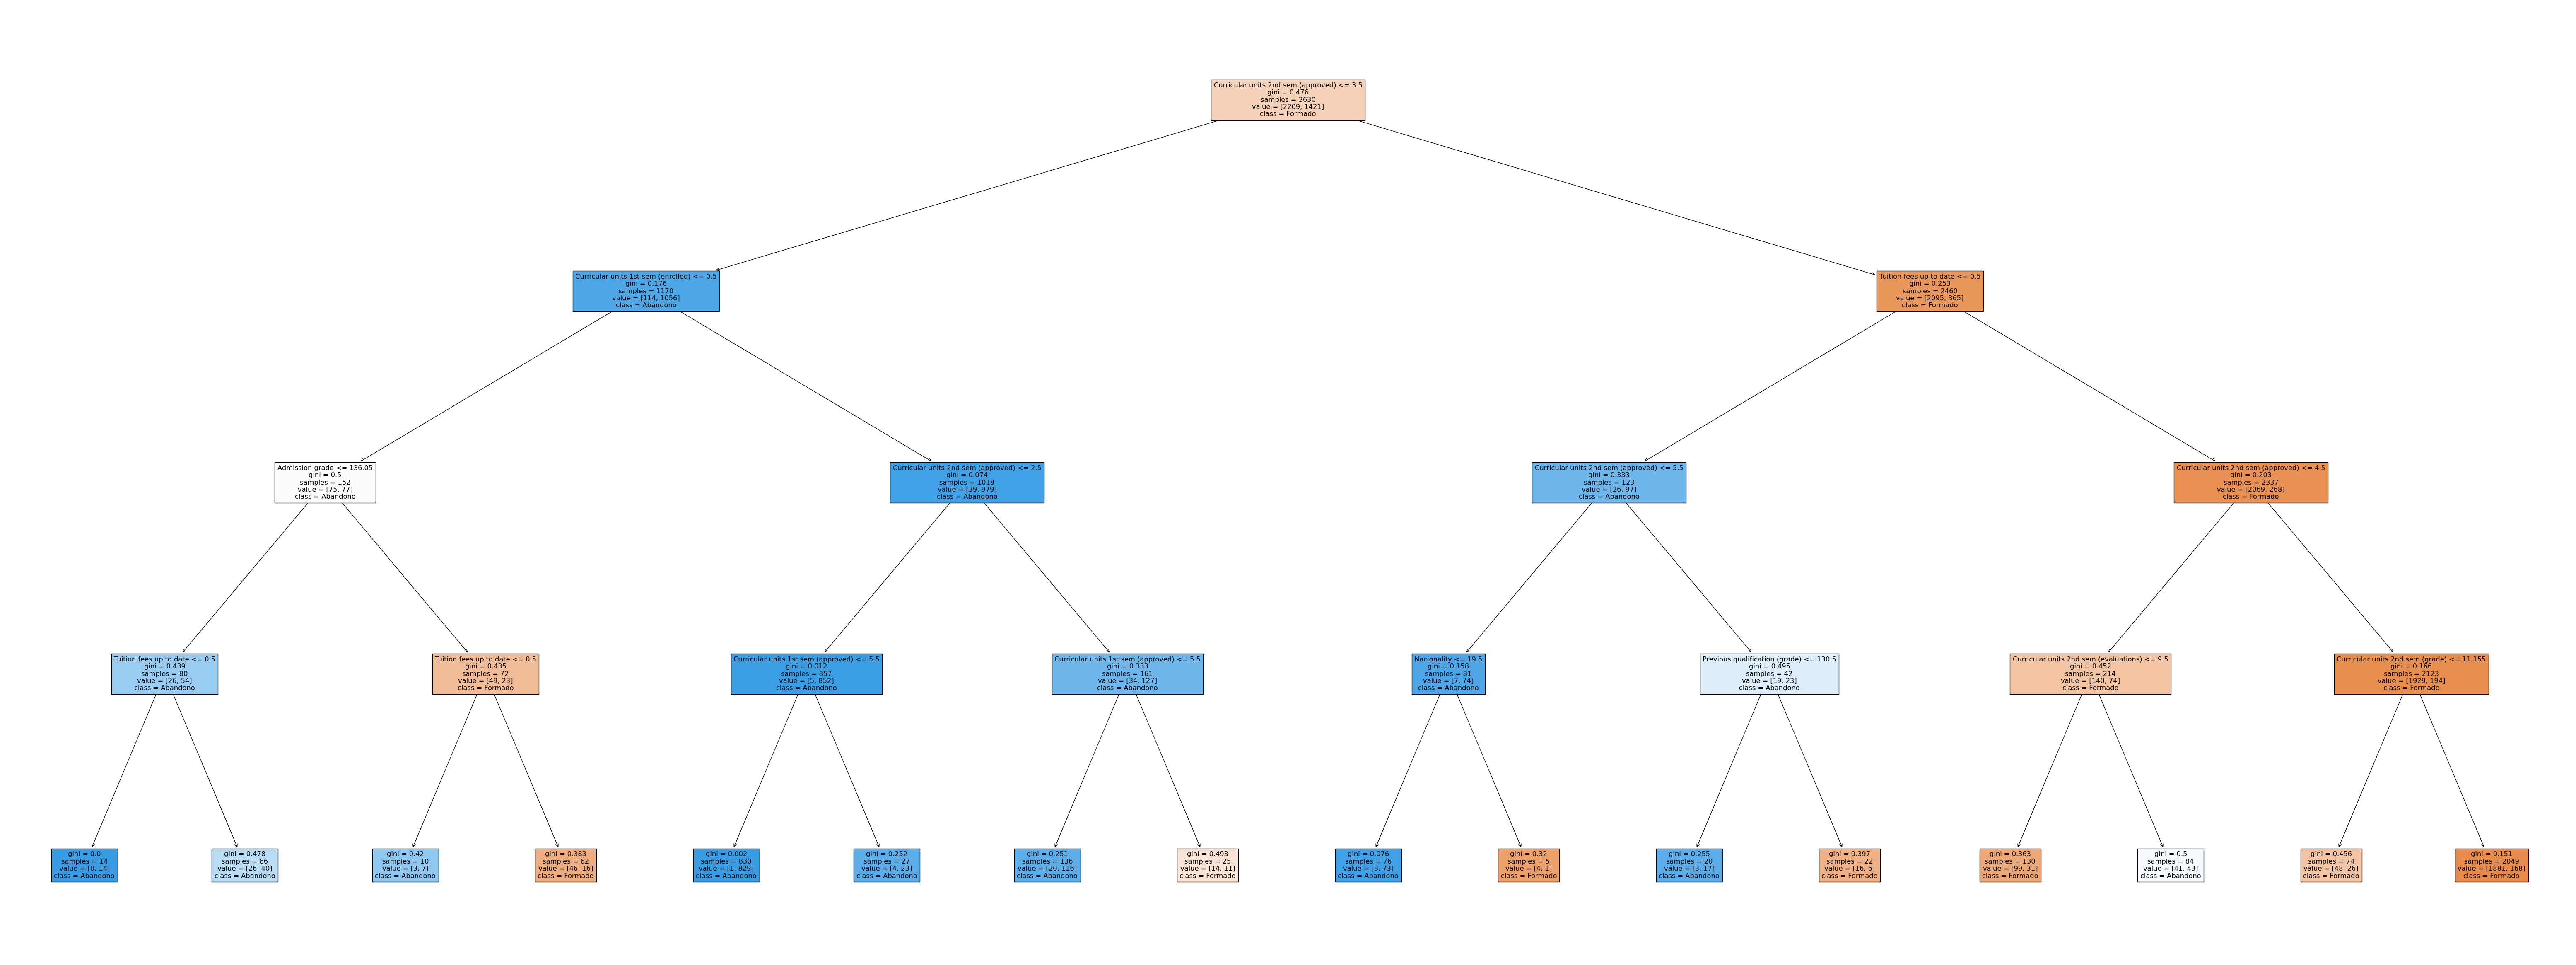

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (80,30)
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=4,random_state=1)
clf.fit(X, y)
f1_formando = metrics.f1_score(y, clf.predict(X), pos_label=0)
f1_evasao = metrics.f1_score(y, clf.predict(X), pos_label=1)
display(f'Acertos Formados: {f1_formando:.2%}  Abandonos: {f1_evasao:.2%}')

_ = tree.plot_tree(clf, feature_names=dropout.columns[:-1], class_names=['Formado','Abandono'], filled=True)

Visualizando regras de forma descritiva:

In [22]:
print(tree.export_text(clf, feature_names=list(dropout.columns[:-1])))

|--- Curricular units 2nd sem (approved) <= 3.50
|   |--- Curricular units 1st sem (enrolled) <= 0.50
|   |   |--- Admission grade <= 136.05
|   |   |   |--- Tuition fees up to date <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Tuition fees up to date >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Admission grade >  136.05
|   |   |   |--- Tuition fees up to date <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Tuition fees up to date >  0.50
|   |   |   |   |--- class: 0
|   |--- Curricular units 1st sem (enrolled) >  0.50
|   |   |--- Curricular units 2nd sem (approved) <= 2.50
|   |   |   |--- Curricular units 1st sem (approved) <= 5.50
|   |   |   |   |--- class: 1
|   |   |   |--- Curricular units 1st sem (approved) >  5.50
|   |   |   |   |--- class: 1
|   |   |--- Curricular units 2nd sem (approved) >  2.50
|   |   |   |--- Curricular units 1st sem (approved) <= 5.50
|   |   |   |   |--- class: 1
|   |   |   |--- Curricular units 1st sem (approved) >  5.50
|  